In [32]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

#IFN in WFI Estimation
# Function for biphasic decay model
def biphasic_decay(t, k1, k2):
    return 0.5 * np.exp(-k1 * t) + 0.5 * np.exp(-k2 * t)

# Function for Weibull decay model
def weibull_decay(t, a, b, k):
    return a * np.exp(-k * (t ** b))

# Function for first-order decay model
def first_order_decay(t, c0, k):
    return c0 * np.exp(-k * t)

# Function for zeroth-order decay model (linear)
def zeroth_order_decay_linear(t, c0, k):
    return np.maximum(c0 - k * t, 0)

# Function to fit the decay models
def fit_decay_models(t_data, conc_data, initial_guesses):
    params_biphasic, _ = curve_fit(biphasic_decay, t_data, conc_data, p0=initial_guesses["biphasic"])
    params_weibull, _ = curve_fit(weibull_decay, t_data, conc_data, p0=initial_guesses["weibull"])
    params_first_order, _ = curve_fit(first_order_decay, t_data, conc_data, p0=initial_guesses["first_order"])
    params_zeroth_order, _ = curve_fit(zeroth_order_decay_linear, t_data, conc_data, p0=initial_guesses["zeroth_order"])
    
    return params_biphasic, params_weibull, params_first_order, params_zeroth_order

# Function to plot the comparison subplot
def plot_comparison_subplot(t_data, conc_20C, conc_37C, params_20C, params_37C, t_high_res):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Comparison of Decay Models for IFN-b Decay at 20°C and 37°C')

    # Helper function to plot for each series
    def plot_series(axes, t_data, conc_data, params, t_high_res, temp_label):
        axes.plot(t_data, conc_data, 'o-', label=f'Original Data ({temp_label})')
        #print(biphasic_decay(t_high_res, *params[0]))
        axes.plot(t_high_res, biphasic_decay(t_high_res, *params[0]), '-', label=f'Biphasic Decay ({temp_label})')
        axes.plot(t_high_res, weibull_decay(t_high_res, *params[1]), '-.', label=f'Weibull Decay ({temp_label})')
        axes.plot(t_high_res, first_order_decay(t_high_res, *params[2]), '-', label=f'First Order Decay ({temp_label})')
        axes.plot(t_high_res, zeroth_order_decay_linear(t_high_res, *params[3]), '-', label=f'Zeroth Order Decay ({temp_label})')
        axes.legend()
        axes.grid(True)

    # 20°C Series (Natural Y-axis)
    axes[0, 0].set_xlabel('Time (hours)')
    axes[0, 0].set_ylabel('Concentration')
    axes[0, 0].set_title('20°C (Natural Y-axis)')
    plot_series(axes[0, 0], t_data, conc_20C, params_20C, t_high_res, '20°C')

    # 37°C Series (Natural Y-axis)
    axes[1, 0].set_xlabel('Time (hours)')
    axes[1, 0].set_ylabel('Concentration')
    axes[1, 0].set_title('37°C (Natural Y-axis)')
    plot_series(axes[1, 0], t_data, conc_37C, params_37C, t_high_res, '37°C')

    # 20°C Series (Log Y-axis)
    axes[0, 1].set_xlabel('Time (hours)')
    axes[0, 1].set_ylabel('Concentration (Log Scale)')
    axes[0, 1].set_title('20°C (Log Y-axis)')
    plot_series(axes[0, 1], t_data, conc_20C, params_20C, t_high_res, '20°C')
    axes[0, 1].set_yscale('log')
    axes[0, 1].set_ylim(1e-1,1e0)

    # 37°C Series (Log Y-axis)
    axes[1, 1].set_xlabel('Time (hours)')
    axes[1, 1].set_ylabel('Concentration (Log Scale)')
    axes[1, 1].set_title('37°C (Log Y-axis)')
    plot_series(axes[1, 1], t_data, conc_37C, params_37C, t_high_res, '37°C')
    axes[1, 1].set_yscale('log')
    axes[1, 1].set_ylim(1e-1,1e0)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
# Initial guesses for fitting the models
initial_guess_biphasic = (1, 1)
initial_guess_weibull = (1, 1, 1)
initial_guess_first_order = (1, 1)
initial_guess_zeroth_order = (1, 0.5)

# Data from Mary et al Figure 2:  https://doi.org/10.3389/fphar.2020.592543
t_data = np.array([0, 0.5, 1, 2])
conc_20C = np.array([0.989403974, 0.548344371, 0.268211921, 0.232450331])
conc_37C = np.array([0.995364238, 0.766887417, 0.188741722, 0.137086093])


# Defining a higher resolution time array for smooth plotting
t_high_res = np.linspace(0, 2, 1000)

initial_guesses_20C_37C = {
    "biphasic": initial_guess_biphasic,
    "weibull": initial_guess_weibull,
    "first_order": initial_guess_first_order,
    "zeroth_order": initial_guess_zeroth_order
}

# Fit the decay models for 20°C series
params_20C = fit_decay_models(t_data, conc_20C, initial_guesses_20C_37C)

# Fit the decay models for 37°C series
params_37C = fit_decay_models(t_data, conc_37C, initial_guesses_20C_37C)

# Create the comparison subplot
plot_comparison_subplot(t_data, conc_20C, conc_37C, params_20C, params_37C, t_high_res)

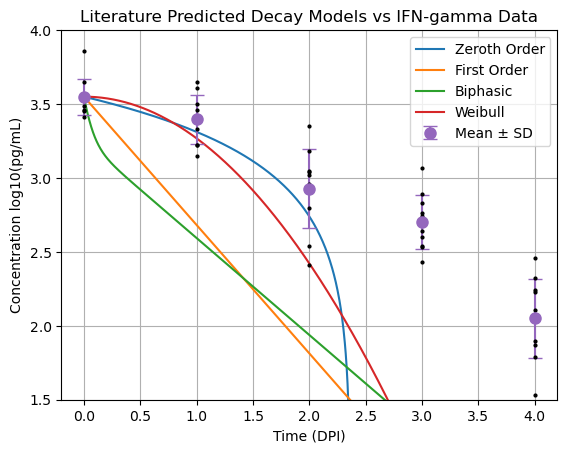

In [51]:
#IFNG Murine Decay
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Constants for the biphasic decay of IFN-gamma
# Estimated from Smith-Jones, https://doi.org/10.1016/S0140-6736(05)63124-8, as 1 hr^-1 and 11 hr^-1
C0g = 10**3.55  # Initial concentration (pg/mL)

C0a = 10** 1.927

# Time array for plotting
t_plot = np.linspace(0, 4, 1000)  # 8+4 DPI

# Biphasic decay model
def biphasic_IFN(C0, t, k1=16.63, k2=1.51):
    return C0/2 * np.exp(-k1 * t) + C0/2 * np.exp(-k2 * t)

# Weibull, 1st and 0th do not have lit parameters discovered yet
# Weibull decay model with parameters adjusted to replicate biphasic decay
def weibull_IFN(C0, t, b=2, k=0.65):
    return C0 * np.exp(-k * (t ** b))

# First order decay model with effective decay rate to replicate biphasic decay
def first_order_IFN(C0, t, k_eff=2):
    return C0 * np.exp(-k_eff * t)

# Zeroth order decay model (linear) for comparison
def zeroth_order_IFN(C0, t, k_zero=1500):
    return np.maximum(C0 - k_zero * t, 0)

# Concentrations using different decay models
C_biphasic = biphasic_IFN(C0g, t_plot)
C_weibull = weibull_IFN(C0g, t_plot)
C_first_order = first_order_IFN(C0g, t_plot)
C_zeroth_order = zeroth_order_IFN(C0g, t_plot)

# IFN-gamma concentration data
time_data = [0, 1, 2, 3, 4]
IFNG_data_raw = [
    [3.57, 3.45, 3.53, 3.49, 3.54, 3.54, 3.86, 3.65, 3.46, 3.41],
    [3.15, 3.42, 3.22, 3.46, 3.5, 3.33, 3.65, 3.22, 3.61],
    [3.04, 2.91, 2.41, 2.96, 2.54, 2.8, 3.02, 3.18, 3.35, 3.05],
    [2.53, 2.83, 2.6, 2.76, 2.89, 2.43, 2.54, 3.07, 2.64, 2.74],
    [2.23, 1.87, 1.79, 1.53, 1.9, 2.06, 2.46, 2.11, 2.32, 2.24]
]

# Calculating mean and standard deviation for plotting
IFNG_mean = [np.mean(replicates) for replicates in IFNG_data_raw]
IFNG_std = [np.std(replicates) for replicates in IFNG_data_raw]

# Plotting literature predicted models
plt.plot(t_plot, np.log10(C_zeroth_order+1e-6), label="Zeroth Order")
plt.plot(t_plot, np.log10(C_first_order+1e-6), label="First Order")

plt.plot(t_plot, np.log10(C_biphasic+1e-6), label="Biphasic")
plt.plot(t_plot, np.log10(C_weibull+1e-6), label="Weibull")

# Plotting the mean with standard deviation
plt.errorbar(time_data, IFNG_mean, yerr=IFNG_std, fmt='o', markersize=8, capsize=5, label="Mean ± SD")

# Plotting individual replicates as small markers
for t, replicates in zip(time_data, IFNG_data_raw):
    plt.plot([t] * len(replicates), replicates, 'k.', markersize=4)

plt.xlabel("Time (DPI)")
plt.ylabel("Concentration log10(pg/mL)")
plt.title("Literature Predicted Decay Models vs IFN-gamma Data")
plt.legend()
plt.grid(True)
plt.ylim(1.5, 4)
plt.show()

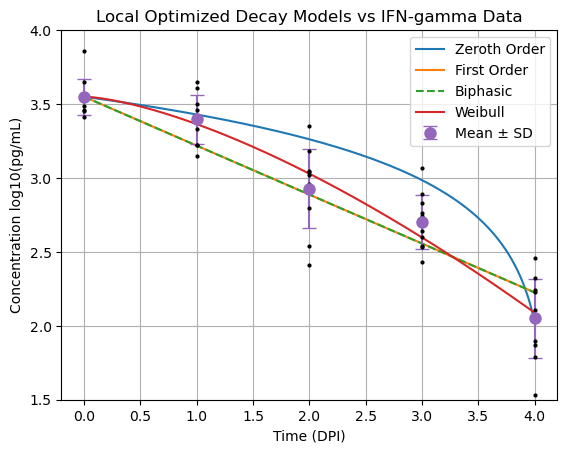

[('Zeroth',
  ('Params', array([860.95951562])),
  ('MSE:', 6.202761655495691),
  ('Logloss:', -11.657179218981021),
  ('AIC:', 27.314358437962042),
  ('AICc:', 33.31435843796204),
  ('BIC:', 26.53323426283024)),
 ('First',
  ('Params', array([0.76288056])),
  ('MSE:', 6.31775989507298),
  ('Logloss:', -11.703104411887022),
  ('AIC:', 27.406208823774044),
  ('AICc:', 33.406208823774044),
  ('BIC:', 26.625084648642243)),
 ('Biphasic',
  ('Params', array([0.76287551, 0.7628882 ])),
  ('MSE:', 6.317760714281675),
  ('Logloss:', -11.703104736055977),
  ('AIC:', 29.406209472111954),
  ('AICc:', 53.406209472111954),
  ('BIC:', 28.234523209414256)),
 ('Weibull',
  ('Params', array([1.48858103, 0.42766937])),
  ('MSE:', 6.2879327824884355),
  ('Logloss:', -11.691273579178239),
  ('AIC:', 29.382547158356477),
  ('AICc:', 53.38254715835647),
  ('BIC:', 28.210860895658776))]

In [37]:
# Fitting to Ivan's IFNG
# Function to fit the biphasic decay model in log space
def log_biphasic_IFNg(t, k1, k2):
    C_biphasic = biphasic_IFN(C0g, t, k1, k2)
    C_biphasic = C_biphasic.clip(min=0.0)
    C_biphasic += 1e-6
    return np.log10(C_biphasic)

# Function to fit the Weibull decay model in log space
def log_weibull_IFNg(t, b, k):
    C_weibull = weibull_IFN(C0g, t, b, k)
    C_weibull = C_weibull.clip(min=0)
    C_weibull += 1e-6
    return np.log10(C_weibull)

# Function to fit the zeroth order decay model in log space
def log_zeroth_order_IFNg(t, k_zero):
    C_zeroth = zeroth_order_IFN(C0g, t, k_zero)
    C_zeroth = C_zeroth.clip(min=0.0)
    C_zeroth += 1e-6
    return np.log10(C_zeroth)

# Function to fit the first order decay model in log space
def log_first_order_IFNg(t, k_one):
    C_first = first_order_IFN(C0g, t, k_one)
    C_first = C_first.clip(min=0.0)
    C_first += 1e-6
    return np.log10(C_first)

# Fit the zeroth order decay model to the data
params_zeroth_order, covariance_zeroth_order = curve_fit(log_zeroth_order_IFNg, time_data, IFNG_mean)
zeroth_order_results = (params_zeroth_order, np.sqrt(np.diag(covariance_zeroth_order)))

# Fit the first order decay model to the data 
params_first_order, covariance_first_order = curve_fit(log_first_order_IFNg, time_data, IFNG_mean)
first_order_results = (params_first_order, np.sqrt(np.diag(covariance_first_order)))

# Fit the biphasic decay model to the data
params_biphasic, covariance_biphasic = curve_fit(log_biphasic_IFNg, time_data, IFNG_mean)
biphasic_results = (params_biphasic, np.sqrt(np.diag(covariance_biphasic)))

# Fit the Weibull decay model to the data
params_weibull, covariance_weibull = curve_fit(log_weibull_IFNg, time_data, IFNG_mean)
weibull_results = (params_weibull, np.sqrt(np.diag(covariance_weibull)))

# Calculating the concentrations using the newly fitted models
C_biphasic = biphasic_IFN(C0g,t_plot, *params_biphasic)
C_weibull = weibull_IFN(C0g,t_plot, *params_weibull)
C_zeroth_order = zeroth_order_IFN(C0g,t_plot, *params_zeroth_order)
C_first_order = first_order_IFN(C0g,t_plot, *params_first_order)

# Plotting literature predicted models
plt.plot(t_plot, np.log10(C_zeroth_order+1e-6), label="Zeroth Order")
plt.plot(t_plot, np.log10(C_first_order+1e-6), label="First Order")
plt.plot(t_plot, np.log10(C_biphasic+1e-6), label="Biphasic", linestyle='--')
plt.plot(t_plot, np.log10(C_weibull+1e-6), label="Weibull")

# Plotting the mean with standard deviation
plt.errorbar(time_data, IFNG_mean, yerr=IFNG_std, fmt='o', markersize=8, capsize=5, label="Mean ± SD")

# Plotting individual replicates as small markers
for t, replicates in zip(time_data, IFNG_data_raw):
    plt.plot([t] * len(replicates), replicates, 'k.', markersize=4)

plt.xlabel("Time (DPI)")
plt.ylabel("Concentration log10(pg/mL)")
plt.title("Local Optimized Decay Models vs IFN-gamma Data")
plt.legend()
plt.grid(True)
plt.ylim(1.5, 4)
plt.show()

# Helper function to compute log-transformed MSE
def calculate_log_mse(model_func, params, data_x, data_y_log):
    predictions_linear = model_func(data_x, *params)
    predictions_log = np.log10(predictions_linear + 1e-6)
    return mean_squared_error(data_y_log, predictions_log)

# Function to calculate Log-Likelihood
def logloss(n, MSE):
    return -n/2*(np.log(MSE)+np.log(2*np.pi)+1)

# Function to calculate AIC
def AIC(LL, n_params):
    return 2 * n_params - 2 * LL

def AICc(AIC, n, k):
    return AIC + 2 * k * (k + 1) / (n - k - 1)

def BIC(k, LL, n):
    return k * np.log(n) - 2 * LL

# Converting time_data to a NumPy array
time_data_array = np.array(time_data)

# Calculating log-transformed MSE and AIC for each model using the correct time_data_array
summary_table_log_corrected = []

# Make a interable of tuples of (model_name, model_func, params)
models = [('Zeroth', (log_zeroth_order_IFNg, params_zeroth_order)), 
          ('First', (log_first_order_IFNg, params_first_order)),
          ('Biphasic', (log_biphasic_IFNg, params_biphasic)),
          ('Weibull', (log_weibull_IFNg, params_weibull))]

# Loop through each model and calculate the MSE and AIC
for model_name, (model_func, model_params) in models:
    mse_log = calculate_log_mse(model_func, model_params, time_data_array, IFNG_mean)
    LL_log = logloss(len(time_data_array), mse_log)
    AIC_log = AIC(LL_log, len(model_params)+1)
    AICc_log = AICc(AIC_log, len(time_data_array), len(model_params)+1)
    BIC_log = BIC(len(model_params)+1, LL_log, len(time_data_array))
    
    summary_table_log_corrected.append(
        (
            (model_name), 
            ('Params',model_params), 
            ('MSE:',mse_log), 
            ('Logloss:', LL_log),
              ('AIC:',AIC_log), 
              ('AICc:',AICc_log), 
              ('BIC:',BIC_log)
              ))

summary_table_log_corrected

/tmp/ipykernel_8944/476263965.py:23: RuntimeWarning: divide by zero encountered in power
  return C0 * np.exp(-k * (t ** b))


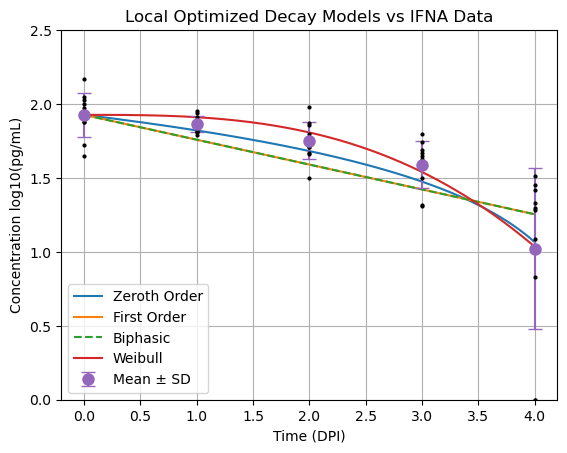

[('Zeroth',
  ('Params', array([18.22820615])),
  ('MSE:', 7.659730338757986),
  ('Logloss:', -12.184634614311703),
  ('AIC:', 28.369269228623406),
  ('AICc:', 34.36926922862341),
  ('BIC:', 27.588145053491605)),
 ('First',
  ('Params', array([0.38737158])),
  ('MSE:', 7.664769400859228),
  ('Logloss:', -12.186278733979057),
  ('AIC:', 28.372557467958114),
  ('AICc:', 34.37255746795812),
  ('BIC:', 27.591433292826313)),
 ('Biphasic',
  ('Params', array([0.38737759, 0.38736561])),
  ('MSE:', 7.664769426040958),
  ('Logloss:', -12.186278742192524),
  ('AIC:', 30.372557484385048),
  ('AICc:', 54.37255748438505),
  ('BIC:', 29.20087122168735)),
 ('Weibull',
  ('Params', array([2.90294387, 0.0367313 ])),
  ('MSE:', 7.591350858760309),
  ('Logloss:', -12.162216551842109),
  ('AIC:', 30.324433103684218),
  ('AICc:', 54.324433103684214),
  ('BIC:', 29.152746840986516))]

In [40]:
# Fitting to IFNA data
IFNA_data_raw = [
    [1.92,2.17,2,2.03,2.05,1.88,1.65,1.88,1.97,1.72],
[1.82,1.79,1.94,1.95,1.86,1.85,1.81,1.91,1.89,1.81],
[1.77,1.67,1.87,1.8,1.98,1.86,1.71,1.5,1.66,1.71],
[1.63,1.32,1.67,1.59,1.31,1.65,1.5,1.74,1.69,1.8],
[1.3,1.51,0,1.33,1.45,1.42,1.28,1.09,0,0.83]]

# Calculating mean and standard deviation for plotting
IFNA_mean = [np.mean(replicates) for replicates in IFNA_data_raw]
IFNA_std = [np.std(replicates) for replicates in IFNA_data_raw]

# Function to fit the biphasic decay model in log space
def log_biphasic_IFNa(t, k1, k2):
    C_biphasic = biphasic_IFN(C0a, t, k1, k2)
    C_biphasic = C_biphasic.clip(min=0.0)
    C_biphasic += 1e-6
    return np.log10(C_biphasic)

# Function to fit the Weibull decay model in log space
def log_weibull_IFNa(t, b, k):
    C_weibull = weibull_IFN(C0a, t, b, k)
    C_weibull = C_weibull.clip(min=0)
    C_weibull += 1e-6
    return np.log10(C_weibull)

# Function to fit the zeroth order decay model in log space
def log_zeroth_order_IFNa(t, k_zero):
    C_zeroth = zeroth_order_IFN(C0a, t, k_zero)
    C_zeroth = C_zeroth.clip(min=0.0)
    C_zeroth += 1e-6
    return np.log10(C_zeroth)

# Function to fit the first order decay model in log space
def log_first_order_IFNa(t, k_one):
    C_first = first_order_IFN(C0a, t, k_one)
    C_first = C_first.clip(min=0.0)
    C_first += 1e-6
    return np.log10(C_first)

# Fit the zeroth order decay model to the data
params_zeroth_order, covariance_zeroth_order = curve_fit(log_zeroth_order_IFNa, time_data, IFNA_mean)
zeroth_order_results = (params_zeroth_order, np.sqrt(np.diag(covariance_zeroth_order)))

# Fit the first order decay model to the data 
params_first_order, covariance_first_order = curve_fit(log_first_order_IFNa, time_data, IFNA_mean)
first_order_results = (params_first_order, np.sqrt(np.diag(covariance_first_order)))

# Fit the biphasic decay model to the data
params_biphasic, covariance_biphasic = curve_fit(log_biphasic_IFNa, time_data, IFNA_mean)
biphasic_results = (params_biphasic, np.sqrt(np.diag(covariance_biphasic)))

# Fit the Weibull decay model to the data
params_weibull, covariance_weibull = curve_fit(log_weibull_IFNa, time_data, IFNA_mean)
weibull_results = (params_weibull, np.sqrt(np.diag(covariance_weibull)))

# Calculating the concentrations using the newly fitted models
C_biphasic = biphasic_IFN(C0a, t_plot, *params_biphasic)
C_weibull = weibull_IFN(C0a, t_plot, *params_weibull)
C_zeroth_order = zeroth_order_IFN(C0a, t_plot, *params_zeroth_order)
C_first_order = first_order_IFN(C0a, t_plot, *params_first_order)

# Plotting literature predicted models
plt.plot(t_plot, np.log10(C_zeroth_order+1e-6), label="Zeroth Order")
plt.plot(t_plot, np.log10(C_first_order+1e-6), label="First Order")
plt.plot(t_plot, np.log10(C_biphasic+1e-6), label="Biphasic", linestyle='--')
plt.plot(t_plot, np.log10(C_weibull+1e-6), label="Weibull")

# Plotting the mean with standard deviation
plt.errorbar(time_data, IFNA_mean, yerr=IFNA_std, fmt='o', markersize=8, capsize=5, label="Mean ± SD")

# Plotting individual replicates as small markers
for t, replicates in zip(time_data, IFNA_data_raw):
    plt.plot([t] * len(replicates), replicates, 'k.', markersize=4)

plt.xlabel("Time (DPI)")
plt.ylabel("Concentration log10(pg/mL)")
plt.title("Local Optimized Decay Models vs IFNA Data")
plt.legend()
plt.grid(True)
plt.ylim(0, 2.5)
plt.show()

# Converting time_data to a NumPy array
time_data_array = np.array(time_data)

# Calculating log-transformed MSE and AIC for each model using the correct time_data_array
summary_table_log_corrected = []

# Make a interable of tuples of (model_name, model_func, params)
models = [('Zeroth', (log_zeroth_order_IFNa, params_zeroth_order)), 
          ('First', (log_first_order_IFNa, params_first_order)),
          ('Biphasic', (log_biphasic_IFNa, params_biphasic)),
          ('Weibull', (log_weibull_IFNa, params_weibull))]

# Loop through each model and calculate the MSE and AIC
for model_name, (model_func, model_params) in models:
    mse_log = calculate_log_mse(model_func, model_params, time_data_array, IFNG_mean)
    LL_log = logloss(len(time_data_array), mse_log)
    AIC_log = AIC(LL_log, len(model_params)+1)
    AICc_log = AICc(AIC_log, len(time_data_array), len(model_params)+1)
    BIC_log = BIC(len(model_params)+1, LL_log, len(time_data_array))
    
    summary_table_log_corrected.append(
        (
            (model_name), 
            ('Params',model_params), 
            ('MSE:',mse_log), 
            ('Logloss:', LL_log),
              ('AIC:',AIC_log), 
              ('AICc:',AICc_log), 
              ('BIC:',BIC_log)
              ))

summary_table_log_corrected